In [1]:
from lightlab.equipment.visa_bases import VISAInstrumentDriver
from lightlab.laboratory.instruments import Instrument
import numpy as np
import time
from lightlab.equipment.lab_instruments import Keithley_2400_SM
from lightlab.equipment.lab_instruments import Tektronix_TDS6154C_Oscope
import pyvisa
from lightlab.util.data import Waveform
from lightlab.util.sweep import NdSweeper

2021-09-13 15:10:04,023 - WARNING - lightlab:
	[WinError 2] The system cannot find the file specified
2021-09-13 15:10:04,025 - WARNING - lightlab:
	io.projectDir is typically set to the root of the git repository containing this file. Because none was found, projectDir was set to 'C:\Users\RandLab\Desktop\Lianfeng'. To remove this warning, please create a git repository in 'C:\Users\RandLab\Desktop\Lianfeng' or any of its parent directories.
------------------------------
To create a git repository in a folder, run the following commands:

$ cd folder/
$ git init .


In [2]:
#Pulser driver
from lightlab.equipment.visa_bases import VISAInstrumentDriver
from lightlab.laboratory.instruments import Instrument
class Avtech_7B_B_Driver(VISAInstrumentDriver):
    '''An Avtech-7B-B pulser driver - will work with most -B Avtech generators.
        Manual: https://www.avtechpulse.com/manuals/programming/programming.pdf
    '''
    instrument_category = Instrument
    
    def __init__(self, name=None, address=None):
        VISAInstrumentDriver.__init__(self, name=name, address=address)
    # Sets conditions to what they are when the pulser is turned on.
    def startup(self):
        self.write('*RST') 
    # Set pulse width
    def set_PW(self, pw):
        self.write('pulse:width {:s}'.format(pw))
    #S MS US NS PS - must write pulse width as e.g. 100ns 100us etc.
    # Set pulse delay
    def set_PD(self, pd):
        self.write('pulse:delay {:s}'.format(pd))
    #S MS US NS PS - must write pulse width as e.g. 100ns 100us etc.               
    def set_freq(self, freq):
        self.write('source:frequency {:s}'.format(freq))
    #MHZ KHZ HZ UHZ - write freq as 1 KHz, default unit is hertz so 1000 = 1000 Hz, scientific notation works
    def query_pw(self, limit):
        self.write('pulse:width? {:s}'.format(limit) )              
    def set_volt(self,volt):
        self.write('volt {:s}'.format(volt))
    def turn_on(self):
        self.write('output on')
    def turn_off(self):
        self.write('output off')    

In [3]:
#Tektronix driver
class Tektronix_TDS3054B(VISAInstrumentDriver):
    '''http://ece-research.unm.edu/jimp/650/instr_docs/tds3000_prog.pdf
    '''
    instrument_category = Instrument
    totalChans = 4
    isSampling = None
    _runModeParam = 1
    _runModeSingleShot = None
   
    
    def __init__(self, name=None, address=None):
        VISAInstrumentDriver.__init__(self, name=name, address=address)
       # Turns output off and sets output level to zero.
    def startup(self):
        self.write('*RST') 
    # Select measure function - by default CURR    
    def timeBaseConfig(self, avgCnt=None, duration=None):
        self.write('HORIZONTAL:MAIN:SAMPLERATE', 2.5e9)
        if avgCnt is not None and avgCnt > 1:
            self.write('ACQUIRE:NUMAVG', avgCnt)
        if duration is not None:
            self.write('HORIZONTAL:MAIN:SCALE', duration / 10)
            self.write('HORIZONTAL:RECORDLENGTH', 10 * int(duration * 2.5e9))
            self.setConfigParam('DATA:START', 1)
            self.setConfigParam('DATA:STOP', int(duration * 2.5e9))
            
    
    def _triggerAcquire(self, timeout=None):
        ''' Sends a signal to the scope to wait for a trigger event.
            Waits until acquisition completes or timeout (in seconds).

            If timeout is very long, it will try a test first
        '''
        if timeout is None:
            timeout = self.timeout / 1e3
        if timeout > 60:
            logger.warning(f'Long timeout {timeout} specified, testing')
            old_avgCnt = self.timebaseConfig()['avgCnt']
            self.timebaseConfig(avgCnt=2)
            self._triggerAcquire(timeout=10)
            logger.warning('Test succeeded. Doing long average now')
            self.timebaseConfig(avgCnt=old_avgCnt)
        self.write('ACQUIRE:STATE 1')  # activate the trigger listener
        # Bus and entire program stall until acquisition completes. Maximum of 30 seconds
        self.wait(int(timeout * 1e3))

    def __transferData(self, chan):
        ''' Returns the raw data pulled from the scope as time (seconds) and voltage (Volts)
            Args:
                chan (int): one channel at a time

            Returns:
                :mod:`data.Waveform`: a time, voltage paired signal

            Todo:
                Make this binary transfer to go even faster
        '''
        chStr = 'CH' + str(chan)
        self.write('DATA:ENCDG ASCII')
        self.write('DATA:SOURCE '+chStr)

        voltRaw = self.query_ascii_values('CURV?')
        return voltRaw

    
    
    def __getUnit(self):
        ''' Gets the unit of the waveform as a string.

            Normally, this will be '"V"', which can be converted to 'V'
        '''

        yunit_query = self.query('WFMPRE:YUNIT?')
        return yunit_query.replace('"', '')


    
    def __scaleData(self, voltRaw):
        ''' Scale to second and voltage units.

            DSA and DPO are very annoying about treating ymult and yscale differently.
            TDS uses ymult not yscale

            Args:
                voltRaw (ndarray): what is returned from ``__transferData``

            Returns:
                (ndarray): time in seconds, centered at t=0 regardless of timebase position
                (ndarray): voltage in volts

            Notes:
                The formula for real voltage should be (Y - YOFF) * YSCALE + YZERO.
                The Y represents the position of the sampled point on-screen,
                YZERO, the reference voltage, YOFF, the offset position, and
                YSCALE, the conversion factor between position and voltage.
        '''
        #get = lambda param: float(self.getConfigParam('WFMOUTPRE:' + param, forceHardware=True))
        

        voltage = (np.array(voltRaw) - float(self.query('WFMPRE:YOFF?'))) \
            * float(self.query('WFMPRE:YMULT?')) \
            + float(self.query('WFMPRE:YZERO?'))
    
    
        sample_rate = 1/float(self.query('WFMPre:XINcr?'))
        # time = np.linspace(-1, 1, len(voltage)) / 2 * timeDivision * 10
        time = np.arange(len(voltage)) / sample_rate
        time -= np.mean(time)

        return time, voltage

    
    def run(self, continuousRun=True):
        ''' Sets the scope to continuous run mode, so you can look at it in lab,
            or to single-shot mode, so that data can be acquired

            Args:
                continuousRun (bool)
        '''
    
        
        if continuousRun:
            self.write(self._runModeParam,'RUNSTOP')
            
        else:
            self._runModeSingleShot
            
        if continuousRun:
            self.write('ACQUIRE:STATE', 1)
    
    
    def _setupSingleShot(self, isSampling):
        ''' Set up a single shot acquisition.

                Not running continuous, and
                acquire mode set SAMPLE/AVERAGE

            Subclasses usually have additional settings to set here.

            Args:
                isSampling (bool): is it in sampling (True) or averaging (False) mode
                forcing (bool): if False, trusts that no manual changes were made, except to run continuous/RUNSTOP

            Todo:
                Missing DPO trigger source setting.
                Should we force it when averaging?
                Probably not because it could be CH1, CH2, AUX.
        '''
        self.run(False)
        
        if isSampling:
            self.write('ACQUIRE:MODE SAMPLE')
        else: self.write('ACQUIRE:MODE AVERAGE')
                          
            
    def acquire(self, chans=None, avgCnt=0, duration=0, timeout = None):

        for c in chans:
            if c > self.totalChans:
                raise Exception('Received channel: ' + str(c) +
                                '. Max channels of this scope is ' + str(self.totalChans))

        # Channel select
        for ich in range(1, 1 + self.totalChans):
            thisState = 1 if ich in chans else 0
            self.write('SELECT:CH' + str(ich))

            
            
        isSampling = 0
        #isSampling = 1
        self._setupSingleShot(isSampling)    
        self._triggerAcquire(timeout=timeout)  
        
        wfms = [None] * len(chans)
        for i, c in enumerate(chans):
            vRaw = self.__transferData(c)
            t, v = self.__scaleData(vRaw)
            unit = self.__getUnit()
            wfms[i] = Waveform(t, v, unit=unit)

        return wfms           
                   

In [4]:
#START SCOPE
scope = Tektronix_TDS3054B(name='My scope', address='GPIB0::2::INSTR')
print(scope.driver.instrID())
if scope.isLive(): 
    print('Connection is good for scope') 
    


2021-09-13 15:10:05,763 - INFO - lightlab:
	Found My scope in GPIB0::2::INSTR.


TEKTRONIX,TDS 3054B,0,CF:91.1CT FV:v3.34 TDS3GV:v1.00 TDS3AAM:v1.00 TDS3FFT:v1.00 TDS3TRG:v1.00
Connection is good for scope


In [5]:
#START PULSER
av = Avtech_7B_B_Driver(name='My Pulser', address='GPIB0::14::INSTR')
#av.driver.instrID()
if av.isLive():
    print('Connection is good for Avtech') 

2021-09-13 15:10:06,554 - INFO - lightlab:
	Found My Pulser in GPIB0::14::INSTR.


Connection is good for Avtech


In [7]:
# set pulser


av.driver.set_PW('30ns')
av.driver.set_freq('5')
av.driver.set_volt('19V')
av.driver.turn_on()

In [8]:
# stop pulser

av.driver.turn_off()



##### 

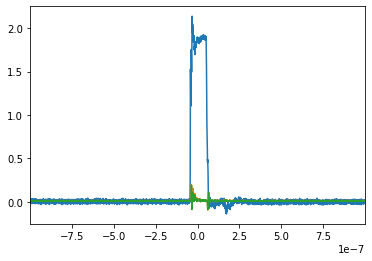

In [577]:
# Single-time test, save pulsing and stop

import json

# A2=4*10**(-5) # Device area in cm2
# A3=4*10**(-4)
# A4=0.002
# A5=0.01
# A6=0.1

# A7=0.02*0.02 #200 um * 200 um laser, in cm2

# A9=0.01*0.01 #100 um * 100 um laser, in cm2

# A8=2*10**(-4)


# A=A7


# R1=25
# R2=50


# R=R2


voltage = str(80)



# set pulser

# av.driver.set_PW('10ns')
# av.driver.set_freq('3Hz')
# av.driver.set_volt(voltage)
# av.driver.turn_on()



# time.sleep(0.1)

# channel 1
chan = 1

a = scope.driver.acquire([chan], timeout=50)[0].getData()
scope.driver.acquire([chan], timeout=50)[0].simplePlot()
b = np.asarray(a)

file = open('C:/lianfeng/20210905/Ch1_{0}.json'.format(voltage), 'a')
json.dump(b.tolist(), file)

# time.sleep(0.1)

#channel 3
chan = 3

a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
b = np.asarray(a)

file = open('C:/lianfeng/20210905/Ch3_{0}.json'.format(voltage), 'a')
json.dump(b.tolist(), file)



# # channel 2
# chan = 2
# avgCnt=5, duration=200e-6
# a = scope.driver.acquire([chan], timeout=50)[0].getData()
# scope.driver.acquire([chan], timeout=50)[0].simplePlot()
# b = np.asarray(a)

# file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
# json.dump(b.tolist(), file)

# time.sleep(0.1)

# trash save
chan = 3

#avgCnt=1, duration=200e-6
a = scope.driver.acquire([chan], timeout=50)[0].getData()
scope.driver.acquire([chan], timeout=50)[0].simplePlot()
b = np.asarray(a)

file = open('C:/lianfeng/trash/trash.json', 'a')
json.dump(b.tolist(), file)

time.sleep(0.1) 

#stop pulser
av.driver.turn_off()









In [ ]:
# stability test and save pulsing. No stop.

import json

# A2=4*10**(-5) # Device area in cm2
# A3=4*10**(-4)
# A4=0.002
# A5=0.01
# A6=0.1

# A7=0.02*0.02 #200 um * 200 um laser, in cm2

# A9=0.01*0.01 #100 um * 100 um laser, in cm2

# A8=2*10**(-4)


# A=A7


# R1=25
# R2=50


# R=R2

Vra1 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage1 in Vra1:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time1/Ch1_{0}.json'.format(voltage1), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time1/Ch3_{0}.json'.format(voltage1), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 



Vra2 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage2 in Vra2:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time2/Ch1_{0}.json'.format(voltage2), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time2/Ch3_{0}.json'.format(voltage2), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
Vra3 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage3 in Vra3:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time3/Ch1_{0}.json'.format(voltage3), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time3/Ch3_{0}.json'.format(voltage3), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
Vra4 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage4 in Vra4:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time4/Ch1_{0}.json'.format(voltage4), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time4/Ch3_{0}.json'.format(voltage4), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    

    
    
    
    
Vra5 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage5 in Vra5:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time5/Ch1_{0}.json'.format(voltage5), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time5/Ch3_{0}.json'.format(voltage5), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
    
Vra6 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage6 in Vra6:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time6/Ch1_{0}.json'.format(voltage6), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time6/Ch3_{0}.json'.format(voltage6), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
    
Vra7 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage7 in Vra7:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time7/Ch1_{0}.json'.format(voltage7), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time7/Ch3_{0}.json'.format(voltage7), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
    
Vra8 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage8 in Vra8:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time8/Ch1_{0}.json'.format(voltage8), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time8/Ch3_{0}.json'.format(voltage8), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 
    
    
    
Vra9 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage9 in Vra9:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time9/Ch1_{0}.json'.format(voltage9), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time9/Ch3_{0}.json'.format(voltage9), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 

    
Vra10 = [str(i) for i in [0,300,900,1500,2100,2700,3300,3900,4500,5100,5700,6300,6900,7500,8100,8700,9300,9900,10500,11100,11700,12300,12900,13500,14100,14700,15300,15900,16500,17100,17700,18300,18900,19500,20100,20700,21300,21900,22500,23100,23700,24300,24900,25500,26100,26700,27300,27900,28500,29100,29700,30300,30900,31500,32100,32700,33300,33900,34500,35100,35700,36300,36900,37500,38100,38700,39300,39900,40500,41100,41700,42300,42900,43500,44100,44700,45300,45900,46500,47100,47700,48300,48900,49500,50100,50700,51300,51900,52500,53100,53700,54300,54900,55500,56100,56700,57300,57900,58500,59100,59700,60300,60900,61500,52100,62700,63300,63900,64500,65100,65700,66300,66900,67500,68100,68700,69300,69900,70500,71100,71700,72300,72900,73500,74100,74700,75300,75900,76500,77100,77700,78300,78900,79500,80100,80700,81300,81900,82500,83100,83700,84300,84900,85500,86100,86700,87300,87900,88500,89100,90300,90900,91500,92100,92700,93300,93900,94500,95100,95700,96300,96900,97500,98100,98700,99300,99900,100500,101100,101700,102300,102900,103500,104100,104700,105300,105900,106500,107100,107700,108300,108900,109500,110100,110700,111300,111900,112500,113100,113700,114300,114900,115500,116100,116700,117300,117900,118500,119100,119700,120300,120900,121500,122100,122700,123300,123900,124500,125100,125700,126300,126900,127500,128100,128700,129300,129900,130500,131100]]


for voltage10 in Vra10:


    chan = 1

    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time10/Ch1_{0}.json'.format(voltage10), 'a')
    json.dump(b.tolist(), file)

    # time.sleep(0.1)

    #channel 3
    chan = 3

    a = scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].getData()
    scope.driver.acquire([chan], avgCnt=5, duration=200e-6, timeout=35)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/20210905/Time10/Ch3_{0}.json'.format(voltage10), 'a')
    json.dump(b.tolist(), file)



    # # channel 2
    # chan = 2
    # avgCnt=5, duration=200e-6
    # a = scope.driver.acquire([chan], timeout=50)[0].getData()
    # scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    # b = np.asarray(a)

    # file = open('/Users/lucas/Google Drive/data/Pulsed LED/20200201-DC+pulsed/100 um by 100 um normal doped PolyTPD-10 nm undoped POPy2/try_Ch2_{0}.json'.format(voltage), 'a')
    # json.dump(b.tolist(), file)

    # time.sleep(0.1)

    # trash save
    chan = 3

    #avgCnt=1, duration=200e-6
    a = scope.driver.acquire([chan], timeout=50)[0].getData()
    scope.driver.acquire([chan], timeout=50)[0].simplePlot()
    b = np.asarray(a)

    file = open('C:/lianfeng/trash/trash.json', 'a')
    json.dump(b.tolist(), file)

    time.sleep(600) 
    
    

# stop pulser
# av.driver.turn_off()





# with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190801/try_Ch1_{0}.json'.format(voltage)) as f:
#     data_ch1 = json.load(f)

# #with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch2_{0}_15ns.json'.format(voltage)) as f:
# #    data_ch2 = json.load(f)    


# with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch3_{0}_15ns.json'.format(voltage)) as f:
#     data_ch3 = json.load(f)
    
#     #length=10000

# pick=3000 #put the pulse around the 3rd grid

# V_chan1=sum(data_ch1[1][pick:(pick+50)])/51

# V_chan2=sum(data_ch2[1][pick:(pick+50)])/51

# V_chan3=sum(data_ch3[1][pick:(pick+50)])/51

# CurrentDensity=(10*V_chan1-V_chan2)/(R*A)


# print(10*V_chan1)
# print(V_chan2)
# print(V_chan3)
# print(CurrentDensity)
    





In [1]:
# stop pulser
av.driver.turn_off()

NameError: name 'av' is not defined

In [ ]:
# DATA PROCESSING

import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


voltage = str(0)

    
#with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch1_{0}.json'.format(voltage)) as f:
#    data_ch1 = json.load(f)

with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch2_{0}_15ns.json'.format(voltage)) as f:
    data_ch2 = json.load(f)    


with open('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/try_Ch3_{0}_15ns.json'.format(voltage)) as f:
    data_ch3 = json.load(f)

    
max(data_ch2[1])


In [ ]:
#CHANNEL 1 VOLTAGE
fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)

    
ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(-0.00000032, 0.00000005)

ax1.plot(data_ch1[0], [(10*i) for i in data_ch1[1]],color='crimson', label = 'Voltage measured in Channel 1')
#ax1.plot(data_ch1[0], data_ch1[1] , color='crimson', label = 'Channel 1')

#ax1.plot(data_ch1[0], data_ch1[1] , color='crimson', label = 'Channel 1')


plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/ch1_voltage_glass_120V_ns_NoLoad.png',  bbox_inches='tight', dpi =200) 


In [ ]:
#CHANNEL 2 current density

A2=4*10**(-5) # Device area in cm2
A3=4*10**(-4)
A4=0.002
A5=0.01
A6=0.1

A7=0.02*0.02 #200 um * 200 um laser, in cm2

A8=2*10**(-4)

A=A8

fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Current Density (A/cm2)')
ax1.set_xlim(-0.000001, -0.0000007)
#ax1.plot(data_ch2[0], data_ch2[1] , color='crimson', label = 'Current density measured in Channel 2')
ax1.plot(data_ch2[0], [(i/A) for i in data_ch2[1]],color='blue', label = 'Current density measured in Channel 2')
plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/ch2_current density_200V_15ns.png',  bbox_inches='tight', dpi =200) 

In [ ]:
#CURRENT ON THE DEVICE

A2=4*10**(-5) # Device area in cm2
A3=4*10**(-4)
A4=0.002
A5=0.01
A6=0.1

A7=0.02*0.02 #200 um * 200 um laser, in cm2

A=A7


R1=814 #814 O
R2=177
R3=53.4
R4=10.4
R5=2.4

R=R4


fig1 = plt.figure(figsize=(8,13))
ax2 = fig1.add_subplot(211)



ax2.set_title("Scope Acquisition")    
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current density (A/cm2)')


ax2.set_xlim(-0.00000015, -0.00000008)
#ax2.set_ylim(0, 4000)
ax2.plot(data_ch1[0], [(10*i-j)/(A*R) for i, j in zip(data_ch1[1], data_ch2[1])], color='crimson', label = 'Calculated current density')


plt.legend(loc ='upper right')

plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/grating_current_sa_120V_ns_noLoad.png',  bbox_inches='tight', dpi =200)


In [ ]:
#Photovoltage - channel 3 - light emission intensity

fig = plt.figure(figsize=(8,13))


ax1 = fig.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(-0.000001, -0.0000007)
ax1.plot(data_ch3[0], data_ch3[1] , color='crimson', label = 'Channel 3')

plt.legend(loc ='upper right')
plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190731/ch3_photovoltage_200V_15ns.png',  bbox_inches='tight', dpi =200) 


In [ ]:
#Calculated power from channel 3 - light emission intensity

fig1 = plt.figure(figsize=(8,13))
ax1 = fig1.add_subplot(211)


ax1.set_title("Scope Acquisition")    
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Power (mW)')
ax1.set_xlim(-0.000012, -0.000005)
original = data_ch3[0]
#trim = original[0:9855]


Sensitivity=0.5 #A/W
Load=50

ax1.plot(original, [1000*i/(Sensitivity*Load) for i in data_ch3[1]], color='crimson', label = 'Light Emission Power')
#ax1.plot(trim, data_ch3[1], color='navy', label = 'Channel 3')

plt.legend(loc ='upper right')

plt.savefig('/Users/lucas/Google Drive/Python code/perovskite pulsing/20190708/ch3_photoPower_17V.png',  bbox_inches='tight', dpi =200)



In [ ]:
chan = 1

a = scope.driver.acquire([chan], timeout=None)[0].getData()
scope.driver.acquire([chan], timeout=None)[0].simplePlot()
b = np.asarray(a)
import json
file = open('/Users/lucas/Desktop/trash.json', 'a')
json.dump(b.tolist(), file)



In [ ]:
a = data_ch3[0]
b = a[0: 9855]

In [ ]:
fig1 = plt.figure(figsize=(8,13))
ax2 = fig1.add_subplot(211)


ax2.set_title("Scope Acquisition")    
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Current (A)')


ax2.set_xlim(0.000001, 0.0000095)
ax2.plot(data_ch1[0], [(i - j - 2.02)/3800 for i, j in zip(data_ch1[1], data_ch2[1])], color='crimson', label = 'Difference/resistance')

plt.legend(loc ='upper right')

for i in [0.000001, 0.0000095]:
    np.min( [(i - j - 2.02)/3800 for i, j in zip(data_ch1[1], data_ch2[1])])

In [ ]:
list = []
for i in np.arange(5100,5900,10):
    list.append(data_ch1[1][i])

In [ ]:
np.mean(list)
np.std(list)

In [ ]:
data_ch2[1][6400]

In [ ]:
a =[(i - j)/3800 for i, j in zip(data_ch1[1], data_ch2[1])]

In [ ]:
len(a)

In [ ]:
np.max(data_ch3[1])

In [ ]:
a =[(i - j)/3800 for i, j in zip(data_ch1[1], data_ch2[1])]
a[4000]